# Temporal Analysis
### Exploring how the language and focus of criticism evolve over time

The goal of this analysis is to investigate whether—and how—the language and thematic focus of arts criticism change across historical periods, using the temporal information available in the data.

To structure the workflow, the task is divided into three main parts:

1. **Data preprocessing**  
2. **Model training**  
3. **Results analysis**

---

## 1. Data Preprocessing

The preprocessing pipeline is implemented as standalone Python scripts to ensure **reproducibility**, **stability**, and a clear **separation between data generation and analysis**.

This notebook documents *what* was done during preprocessing.  
For the detailed implementation, please refer to the project repository (see `data_cleaning.py` and `data_merging.py`).

The preprocessing stage consists of two scripts:

- **`data_cleaning.py`**  
  Cleans each file of the original OCR-scanned dataset and produces standardized, processed files.

- **`data_merging.py`**  
  Merges all processed files into a single corpus and performs lemmatization on the text.

---

### 1.1 Input and Output

**Input**

- Directory: `data/raw/`
- Format: CSV files (one file per genre)
- Main columns:
  - `Author`, `Title`, `Publication`, `Date`, `Place`, `Full_text`, `URL`

These raw datasets contain typical OCR noise, inconsistent metadata formatting, and unnormalized text.

**Output**

- Intermediate output: `data/processed/processed_*.csv`
- Final output: `data/merged_data.csv`

The final merged dataset is used as the input for all subsequent analyses in this notebook.

---

### 1.2 Data Cleaning (`data_cleaning.py`)

The first preprocessing stage operates on each raw CSV file independently and performs the following steps:

#### OCR artifact correction
Common OCR-related issues in the text are corrected, including:
- Ligature normalization (e.g., `ﬁ → fi`, `ﬂ → fl`)
- Frequent OCR character confusions (e.g., `0 → o`, `1 → l`)
- Removal of OCR control characters
- Recovery of hyphenated line breaks
- Whitespace normalization

#### General text cleaning
After OCR correction, the text is further standardized by:
- Removing HTML tags and URLs
- Removing uncommon or non-English symbols (while preserving punctuation and hyphens)
- Converting text to lowercase

#### OCR noise ratio estimation
For each document, an **OCR noise ratio** is computed and stored as `OCR_noise_ratio`.  
This metric measures the proportion of tokens that are likely to be OCR noise, based on:
- Dictionary membership
- Token shape and character patterns

It serves as a proxy for text quality and is later used in robustness checks.

#### Metadata standardization
Metadata fields are cleaned and standardized:
- String fields are normalized (e.g., trimming whitespace, consistent capitalization)
- `Date` is parsed into datetime format
- Known column inconsistencies in specific datasets (e.g., Opera and Poetry) are corrected
- Temporal features are extracted:
  - `Year`
  - `Decade`

Each cleaned dataset is saved to `data/processed/` with a standardized schema.

---

### 1.3 Data Merging and Lemmatization (`data_merging.py`)

In the second preprocessing stage, all processed datasets are combined into a single corpus.

#### Dataset merging
- All files in `data/processed/` are loaded and concatenated
- A new categorical variable `genre` is inferred from the file names
- The merged dataset is sorted chronologically by `Year`

#### Lemmatization
To prepare the text for statistical modeling and topic analysis:
- Lemmatization is performed using **spaCy**
- Stopwords, punctuation, and non-alphabetic tokens are removed
- The resulting lemmatized text is stored in the column `Processed_text`

This step reduces lexical sparsity and improves comparability across time periods.

---

### 1.4 Resulting Preprocessed Dataset

The final dataset (`merged_data.csv`) includes:
- Cleaned and standardized metadata
- Temporal variables (`Year`, `Decade`)
- Cleaned full text (`Full_text`)
- OCR quality metric (`OCR_noise_ratio`)
- Lemmatized text for modeling (`Processed_text`)
- Genre labels (`genre`)

This dataset forms the foundation for the model training and temporal analysis presented in the following sections.

---

## 2. Model training

To facilitate observation of the results, I chose to present this part using a notebook.

### 2.1 Input and Output

**Input**

- File: `data/merged_data.csv`
- Main columns used in modeling:
  - `Processed_text`: lemmatized text used as model input
  - `Year`, `Decade`: temporal information for downstream analysis
  - `genre`: genre labels for stratified inspection

**Output**

- A trained topic model
- Topic assignment for each document
- Topic representations (keywords)
- Topic-level statistics over time

The outputs are analyzed and visualized directly in this notebook rather than being saved as standalone files.


### 2.2 Loading and Inspecting the Preprocessed Data

Before training any model, I first load the merged dataset and perform basic inspections
to ensure that the preprocessing step produced a consistent and usable corpus.

In particular, I check:
- The overall size of the dataset
- The availability of the text field used for modeling
- The temporal coverage of the data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

ROOT = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
PROCESSED_DATA_DIR = os.path.join(ROOT, 'data/processed')

In [6]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]

rows = []

for fname in sorted(os.listdir(PROCESSED_DATA_DIR)):
    if not fname.endswith('.csv'):
        continue
    fpath = os.path.join(PROCESSED_DATA_DIR, fname)
    df = pd.read_csv(fpath)
    if "OCR_noise_ratio" not in df.columns:
        continue
    
    desc = df["OCR_noise_ratio"].describe(percentiles=percentiles)
    rows.append({
        "file": fname,
        "count": int(desc["count"]),
        "mean": desc["mean"],
        "std": desc["std"],
        "min": desc["min"],
        "p10": desc["10%"],
        "p25": desc["25%"],
        "p50": desc["50%"],
        "p75": desc["75%"],
        "p90": desc["90%"],
        "max": desc["max"],
    })

stats_df = pd.DataFrame(rows)
print('Distribution data of OCR_noise_ratio:')
stats_df

Distribution data of OCR_noise_ratio:


,file,count,mean,std,min,p10,p25,p50,p75,p90,max
0,processed_Art_exhibitions_gale.csv,2651,0.020051,0.019978,0.0,0.003976,0.008511,0.015625,0.024897,0.039216,0.277778
1,processed_Books_gale.csv,2283,0.130910,0.097669,0.0,0.011084,0.018868,0.153595,0.214876,0.251841,0.486486
2,processed_Concerts_gale.csv,21907,0.022993,0.026530,0.0,0.002404,0.005952,0.014577,0.031332,0.054054,0.443182
3,processed_Dance_gale.csv,3766,0.030706,0.037620,0.0,0.002101,0.006227,0.020202,0.042972,0.068762,0.625000
4,processed_Operas_gale.csv,972,0.013637,0.015586,0.0,0.000789,0.003565,0.008293,0.017033,0.034643,0.137681
5,processed_Poetry_gale.csv,629,0.026957,0.037682,0.0,0.004167,0.009649,0.019120,0.032454,0.049607,0.477124
6,processed_Theater_gale.csv,18036,0.018877,0.024489,0.0,0.000000,0.005155,0.012232,0.023932,0.041383,0.666667


Key Takeaways：

* **Best Performer:** `Operas` has the lowest median noise (0.8%).
* **Critical Issue:** `Books` is a major outlier with a median noise of 15.4%, suggesting systemic OCR failure for this category.
* **Outlier Alert:** All categories except `Operas` contain pages with >40% noise (Max column)

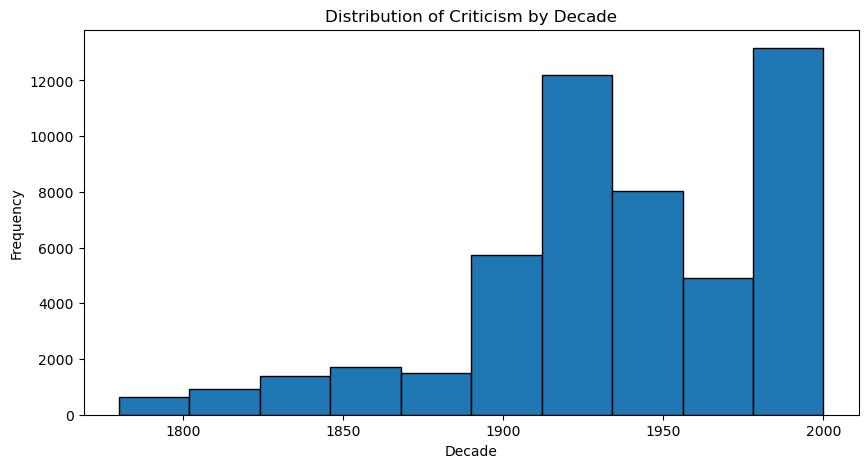

In [7]:
MERGED_DATA_PATH = os.path.join(ROOT, 'data/merged_data.csv')

merged_df = pd.read_csv(MERGED_DATA_PATH)

# distribution of the amount of criticism by decade
plt.figure(figsize=(10,5))
plt.hist(merged_df['Decade'], bins=10, edgecolor='black')
plt.title('Distribution of Criticism by Decade')
plt.xlabel('Decade')
plt.ylabel('Frequency')
plt.show()

Key Insights:

* **Growth:** Significant increase in document frequency starting from **1890**.
* **Peaks:** Highest data density occurs in the **early 1900s** and the **late 1900s**.
* **Imbalance:** The dataset is skewed towards modern records, which may influence longitudinal analysis.

### 2.3 Modeling Strategy and Training

To uncover latent themes in the corpus and study their evolution over time,
I apply a topic modeling approach that operates on the lemmatized text
produced during preprocessing.

The model is trained on the full set of processed documents. Lemmatized text
(`Processed_text`) is used as input to reduce lexical sparsity and improve
topic coherence across long time spans.

The modeling framework combines semantic text representations with clustering
to group documents into topics, and keyword-based representations are used
to interpret the resulting topics.

Model hyperparameters are chosen to balance topic granularity and interpretability,
rather than to optimize a single numerical metric.

In [ ]:
from bertopic import BERTopic
import umap
import hdbscan
from sentence_transformers import SentenceTransformer

df = pd.read_csv(MERGED_DATA_PATH)
# Use the processed comments and the "ten-year" time period as training data
docs = df['Processed_text'].tolist()
timestamps = pd.to_numeric(df["Decade"], errors="coerce").astype("Int64").tolist()

# Clustering related parameters
n_neighbors=15
n_components=5
min_cluster_size=30
min_samples=5

# Define the path to save the model
MODEL_PATH = f"my_bertopic_model_{n_neighbors}_{n_components}_{min_cluster_size}_{min_samples}"

# --- Check if the model already exists ---
if os.path.exists(MODEL_PATH):
    print(f"Loading cached models from {MODEL_PATH}")
    # If the model file exists, load it directly.
    topic_model = BERTopic.load(MODEL_PATH)
    print("Model loading complete!")
else:
    print(f"Model not found. Starting to train a new model")
    
    # embedding model
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Dimensionality reduction model
    umap_model = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.1, metric='cosine', random_state=42)

    # Clustering model
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    #- -- Create and configure the BERTopic model ---
    topic_model = BERTopic(
      embedding_model=embedding_model,
      umap_model=umap_model,
      hdbscan_model=hdbscan_model,
      language="english",
      calculate_probabilities=True,
      verbose=True,
      nr_topics=None      
    )

    # --- Model training ---
    print("Starting to train the BERTopic model, this may take some time")
    embeddings = embedding_model.encode(docs, show_progress_bar=True)
    topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
    
    # --- Reducing Outliers ---
    # Use embeddings to reassign outliers to the nearest topics.
    new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)
    topic_model.update_topics(docs, topics=new_topics)
    
    print("Model training complete!")

    # --- Save the model ---
    print(f"Cache model to {MODEL_PATH}")
    topic_model.save(MODEL_PATH)
    print("Model successfully saved.")

Loading cached models from my_bertopic_model_15_5_30_5
Model loading complete!


I implemented a **BERTopic** pipeline to extract latent themes from the processed criticism text. The model utilizes a transformer-based architecture to capture semantic meaning across different decades.

#### Logic & Pipeline
1. **Persistence:** Implemented a caching layer to load pre-trained models, optimizing computational resources.
2. **Refinement:** Applied an embedding-based outlier reduction strategy to re-integrate noisy data into the most statistically relevant topics.
3. **Temporal Integration:** Prepared the model for "Topics over Time" analysis by converting the `Decade` column into a numerical format.

#### Parameter Intuition
* **UMAP ($n\_neighbors=15$):** Balances local and global features to ensure topics are distinct but cohesive.
* **HDBSCAN ($min\_cluster\_size=30$):** Set to identify substantial, high-level themes rather than granular, low-frequency clusters.
* **Model Selection & Resources:** The choice of these specific parameters and the `all-MiniLM-L6-v2` model was informed by the available **computational resources**. While optimized for the current environment, further performance gains could potentially be achieved through more intensive hyperparameter tuning or by utilizing larger, more complex language models if greater resource capacity is available.

### 2.4 Inspecting Learned Topics

After training, I inspect the learned topics by examining:
- top keywords per topic
- the number of documents assigned to each topic

This step helps verify that the topics correspond to meaningful and interpretable
themes rather than artifacts of noise or preprocessing.

In [14]:
print(f"A total of {len(topic_model.get_topic_info())-1} topics were found.")

# View the first 3 topics
print(topic_model.get_topic_info().head(3))

A total of 137 topics were found.
   Topic  Count                              Name  \
0      0   3967     0_dance_ballet_dancer_company   
1      1   2703  1_exhibition_picture_gallery_art   
2      2   1744           2_opera_signor_act_sing   

                                      Representation  \
0  [dance, ballet, dancer, company, choreography,...   
1  [exhibition, picture, gallery, art, painting, ...   
2  [opera, signor, act, sing, verdi, voice, singe...   

                                 Representative_Docs  
0  [umbrella weather storm val bourne drive force...  
1  [art exhibition interesting numerous exhibitio...  
2  [case opera concert hall correspondent recent ...  


In [12]:
# Get keywords for a specific topic
test_number = 7
print(f"\nThe keyword of Topic({test_number})")
print(topic_model.get_topic(test_number))


The keyword of Topic(7)
[('promenade', np.float64(0.029895014075037137)), ('concerto', np.float64(0.01320502837989594)), ('concert', np.float64(0.011988495210386182)), ('orchestra', np.float64(0.01057093709514336)), ('symphony', np.float64(0.010546322032424027)), ('composer', np.float64(0.009745139174554076)), ('night', np.float64(0.009601228829409487)), ('work', np.float64(0.009547105426349796)), ('programme', np.float64(0.009407152275626596)), ('music', np.float64(0.008304454966130007))]


### 2.5 Linking Topics to Temporal Information

To study how themes evolve over time, I link the topic assignments back to
temporal metadata.

By aggregating topic frequencies by year or decade, I can observe
long-term trends in thematic emphasis across historical periods.

In [15]:
# --- Temporal analysis ---
topics_over_time = topic_model.topics_over_time(
    docs=docs,
    timestamps=timestamps,
    global_tuning=True,
    nr_bins=None  
)

topic_model.visualize_topics_over_time(topics_over_time)

23it [02:07,  5.56s/it]


### 2.6 Transition to Results Analysis

The trained topic model provides a basis for exploring thematic structure
in the corpus. However, the reliability of topic-based analysis depends
strongly on data quality and sample size.

In the following section, I first examine general patterns of language
evolution using simple descriptive statistics. I then conduct a focused
topic analysis restricted to selected time periods where the data quality
and sample size are sufficient to support meaningful interpretation.

Accordingly, the results analysis emphasizes:
- temporal changes in textual characteristics (e.g. text length)
- exploratory topic analysis within selected high-quality periods
- qualitative interpretation of representative topics

## 3. Results Analysis

This section presents the results of the temporal analysis based on the
preprocessed corpus and the trained topic model.

Rather than assuming uniform data quality across the entire timeline,
the analysis proceeds in a stepwise manner. I first examine general
patterns of language evolution using simple descriptive statistics.
These results provide both substantive insights and a baseline for
interpreting more complex, model-based analyses.

Subsequent sections focus on topic analysis, which is restricted to
selected time periods where data quality and sample size are sufficient
to support meaningful interpretation.

### 3.1 Language Evolution: Text Length over Time

Before analyzing thematic content, I first examine how the *form* of
criticism changes over time.

In particular, I analyze the evolution of text length across decades.
Text length serves as a simple but informative proxy for writing style,
editorial conventions, and potential changes in publication practices.
It also provides a useful baseline for understanding later topic-based
analyses.

By focusing on text length, this analysis avoids assumptions about
semantic structure and is therefore less sensitive to OCR noise and
model instability.

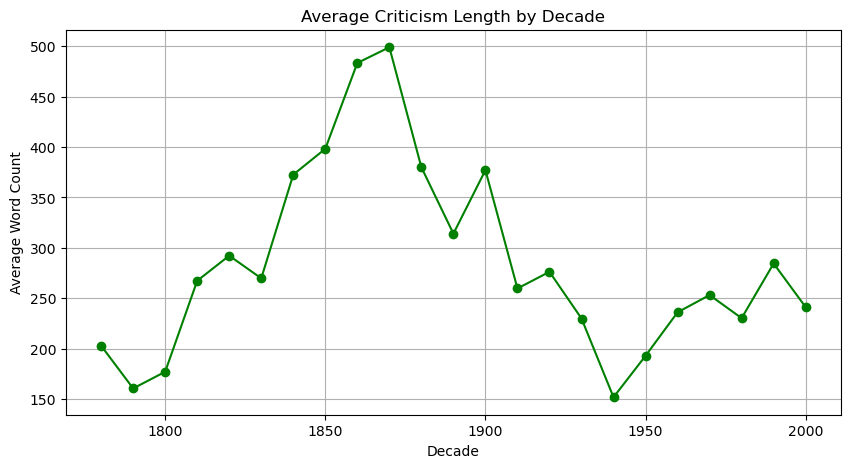

In [16]:
# Calculate word count for each text
merged_df['word_count'] = merged_df['Processed_text'].apply(lambda x: len(str(x).split()))

# Group by Decade and calculate mean word count
length_by_decade = merged_df.groupby('Decade')['word_count'].mean().sort_index()

# Plot
plt.figure(figsize=(10, 5))
length_by_decade.plot(kind='line', marker='o', color='green')
plt.title('Average Criticism Length by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Word Count')
plt.grid(True)
plt.show()

This analysis examines the structural evolution of criticism by tracking average word counts across decades.

| Period | Trend Observation | Possible Context |
| :--- | :--- | :--- |
| **1800 - 1840** | Steady Increase | Expansion of cultural journalism. |
| **1850 - 1870** | **Historical Peak** | Era of long-form, descriptive critical essays (~500 words). |
| **1900 - 1940** | Significant Decline | Shift towards concise, modern journalistic styles. |
| **1950 - 2000** | Stabilization | Standardization of review lengths in modern media. |

#### Historical & Art Historical Contextualization

The fluctuations in text length are not merely technical artifacts but mirror significant shifts in cultural history.

##### 1. The "Golden Age" of Description (1850–1870)
During this period, text length peaked at nearly 500 words. This reflects:
* **The Ekphrastic Tradition:** Before high-quality art reproduction was common, critics used "word-painting" to describe visual works to a distant audience.
* **Intellectual Authority:** Prominent Victorian critics treated reviews as a form of high literature, favoring expansive philosophical and aesthetic arguments.

##### 2. The Rise of Modern Journalism (Post-1890)
The sharp decline into the 20th century coincides with:
* **The Penny Press Era:** Mass-market newspapers demanded shorter, punchier reviews to cater to broader audiences and accommodate limited physical space.
* **Impact of Photography:** As visual documentation became accessible, the necessity for exhaustive physical description diminished, leading to a more concise, opinion-based style.

##### 3. Modern Stabilization
The trend in the late 20th century suggests a professionalization of the "Review" format, settling into a standardized length adapted for contemporary editorial cycles.

### 3.2 Topic Analysis under Data Quality Constraints

While topic modeling provides a useful tool for exploring thematic structure,
its reliability depends strongly on data quality and sample size.

In this dataset, both OCR noise levels and document availability vary
substantially across decades. Rather than applying topic analysis uniformly
across the entire timeline, I first assess data quality and temporal coverage,
and then restrict topic-based analysis to selected periods where the data
supports meaningful interpretation.

This section therefore combines data quality assessment with focused topic
analysis.

#### 3.2.1 Assessing data quality and temporal coverage
To identify time periods suitable for topic analysis, I examine two
basic indicators for each decade:

- the number of available documents(>= 5000)
- the average OCR noise ratio (<= 10%)

Together, these measures provide a pragmatic assessment of whether topic
estimates are likely to be stable and interpretable.

In [27]:

# Calculate data quality metrics by Decade
quality_by_decade = (
    df.groupby("Decade")
      .agg(
          doc_count=("Full_text", "size"),
          mean_ocr_noise=("OCR_noise_ratio", "mean")
      )
      .reset_index()
)

# Data filtering: documents >= 5k, OCR noise ratio <= 0.1
quality_filtered = quality_by_decade[
    (quality_by_decade["mean_ocr_noise"] <= 0.10) &
    (quality_by_decade["doc_count"] >= 5000)
]

quality_filtered

,Decade,doc_count,mean_ocr_noise
14,1920,5153,0.036168
15,1930,7041,0.036572


In [28]:
selected_decades = quality_filtered["Decade"].tolist()

df_selected = df[df["Decade"].isin(selected_decades)].copy()

print("Based on the above criteria, we obtained the following data.")
print("Selected decades:", selected_decades)
print("Subset size:", df_selected.shape)

Based on the above criteria, we obtained the following data.
Selected decades: [1920, 1930]
Subset size: (12194, 12)


Next, we will analyze the keywords for the selected time period.

In [37]:

texts_selected = df_selected["Processed_text"].astype(str).fillna("").tolist()

# Perform topic inference on a subset using the pre-trained topic_model
topics_sel, probs_sel = topic_model.transform(texts_selected)
df_selected = df_selected.copy()
df_selected["topic"] = topics_sel


n = 5  # Take the top 5 topics that appear most frequently.

top_topics = (
    df_selected["topic"]
    .value_counts()
    .head(n)
    .index
    .tolist()
)

top_topics


Batches:   0%|          | 0/382 [00:00<?, ?it/s]

[-1, 1, 3, 0, 8]

In [44]:
for topic_id in top_topics:
    # -1 is the outlier topic, so we can pass it
    if topic_id == -1:
        continue

    words = topic_model.get_topic(topic_id)

    print(f"\nTopic {topic_id}")
    print(", ".join([w for w, _ in words[:40]]))


Topic 1
exhibition, picture, gallery, art, painting, colour, drawing, artist, landscape, painter

Topic 3
book, milford, fiction, edit, publish, translate, press, publication, cape, unwin

Topic 0
dance, ballet, dancer, company, choreography, choreographer, dancing, sadler, new, royal

Topic 8
novel, book, story, net, life, reader, man, love, new, author


As you can see, there are many irrelevant words in the results, so I **manually filtered out some meaningful words** and used AI to analyze their background.

Topic Interpretation in Historical Context (1920s–1930s)

---

**Topic 1**(Visual arts and exhibitions):

**keywords**: exhibition, gallery, art, painting, drawing, artist, landscape, painter

This topic reflects the growing importance of public exhibitions and
gallery-based art practices in the interwar period. Art criticism during
this time increasingly focused on exhibitions and painting as central
sites of cultural discussion.

---

**Topic 3** (Literary publishing and criticism):

**keywords**: book, fiction, publish, edit, translate, press, publication

This topic highlights the close connection between literary criticism
and the publishing industry. Discussions of books are often situated
within broader contexts of editing, translation, and publication,
reflecting the institutionalization of literary culture.

---

**Topic 0** (Dance and ballet performance):

**keywords**: dance, ballet, dancer, choreography, choreographer, company

The prominence of dance-related terms suggests increased critical
attention to performance arts. Reviews emphasize choreography, dancers,
and organized companies, consistent with the professionalization of
dance and ballet in this period.

---

**Topic 8** (Narrative fiction and novels):

**keywords**: novel, book, story, reader, author, love

This topic captures a more content-oriented mode of literary criticism,
with attention to narrative themes, authorship, and reader experience.
Such discussions remain central to literary criticism in the 1920s
and 1930s.

---

Taken together, these topics suggest that arts criticism in the interwar
period spans both institutional contexts and aesthetic interpretation,
across visual arts, performance, and literature.

## Limitations and Future Directions

This study adopts a cautious approach to the temporal analysis of arts criticism, and several limitations should be acknowledged.

First, the corpus exhibits substantial heterogeneity across time and genres, reflecting differences in publication formats, critical conventions, and institutional contexts. While preprocessing and topic modeling mitigate surface-level variation, deeper structural differences remain. Future work could address this by constructing more homogeneous sub-corpora, such as genre- or publication-specific datasets.

Second, topic models are inherently exploratory and sensitive to corpus composition, particularly over long historical periods. To ensure interpretability, this study restricts substantive topic analysis to selected high-quality time spans. Future research could explore multi-stage or hierarchical modeling strategies to better capture both thematic continuity and change.

Finally, the analysis focuses on aggregate, decade-level trends, which may obscure short-term dynamics driven by specific historical or institutional events. Finer temporal resolution and closer integration with qualitative reading would help strengthen the connection between computational patterns and historical interpretation.

Overall, these limitations suggest that future progress depends not only on methodological refinement, but also on improved corpus structuring and interpretive framing.